In [3]:
import sys, pysam, dendropy, subprocess, tqdm, os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import probplot
import mtbvartools as vt
from mtbvartools.vcf import filterDataFrame
from mtbvartools.dasktools import timedsubproc

plt.style.use('paper_style.mplstyle')
env_path = '~/miniforge3/envs/pyseer/bin/'

env = os.environ
conda_path = os.path.dirname(sys.executable)  # store conda path for shell execution
env['PATH'] = conda_path + os.pathsep + env['PATH']

colors = {
    'dred':    '#c54e52', 'lred':    '#f8b1bb',
    'dblue':   '#3c5488', 'lblue':   '#bfd6ef',
    'dgreen':  '#00a087', 'lgreen':  '#c0e6ea',
    'dpink':   '#d78bbb', 'lpink':   '#f9d5e5',
    'dyellow': '#ccb974', 'lyellow': '#fff0c1',
    'gray': '#c0c0c0'}

# local functions

In [4]:
def linearScaleArray(values, new_min, new_max, floor=None, ceiling=None):
    values = np.asarray(values)
    if floor is not None:
        values = np.maximum(values, floor)
    if ceiling is not None:
        values = np.minimum(values, ceiling)
    val_min = np.min(values)
    val_max = np.max(values)
    return ((
        (values - val_min) / (val_max - val_min)) * (new_max - new_min) + new_min)


def filterVCF(input_vcf, output_vcf, variant_indexes):
    open_input = pysam.VariantFile(input_vcf)
    open_output = pysam.VariantFile(output_vcf, mode='w', header=open_input.header)
    unique_variants = np.unique(variant_indexes)
    print(f'writing {len(unique_variants)} unique (pos, ref, alt) records / {len(variant_indexes)} total annotated variants')
    for vidx in variant_indexes:
        region_string = f'{open_input.get_reference_name(0)}:{vidx[0]}-{vidx[0]}'
        for record in open_input.fetch(region=region_string):
            # look for specific record
            is_site = np.all([
                vidx[0] == record.pos,
                vidx[1] == record.ref,
                vidx[2] == record.alts[0],
                len(record.alts) == 1], axis=0)
            if is_site:  # write record, step to next index
                open_output.write(record)
                break
        else:
            raise KeyError(f'No matching record for {vidx} found!')
    open_input.close()
    open_output.close()
    subprocess.call(f'bgzip -f {output_vcf} && {env_path}tabix {output_vcf}.gz', shell=True)

def writeRegionTable(genetable_csv, output_path, geneids, contig_name):
    # write gene whitelist tsv
    gene_table = pd.read_csv(
        genetable_csv, index_col=0)    
    with open(output_path, 'w') as f:
        # write burden test values
        output_rows = []
        for gid, data in gene_table.iterrows():
            if gid in geneids:  # only write provided indexes
                output_rows.append(
                    f'{gid}\t{contig_name}:{data.start + 1}-{data.end + 1}\n')
        f.writelines(output_rows)

timedsubproc(60)
def runPyseerBurdenLMM(phenotypes, tree_path, vcf_path, burden_path, min_freq=5, silent=True):
    vt.contShell('mkdir -p pyseer_tmp')
    # write phenotypes to file MUST BE A SERIES
    phenotypes.to_csv(
        'pyseer_tmp/phenotype.tmp.tsv', sep='\t')
    # load tree
    tree = dendropy.Tree.get(
        path=tree_path,
        schema='newick',
        preserve_underscores=True)
    starting_labels = np.asarray([
        l.taxon.label for l in tree.leaf_nodes()])
    # update tree, keep only strains with phenotypes
    tree.retain_taxa_with_labels(
        phenotypes.index,
        update_bipartitions=True)
    # update tree taxon namespace
    for label in starting_labels[~np.isin(starting_labels, phenotypes.index)]:
        tree.taxon_namespace.discard_taxon_label(label)
    # generate similarity matrix for LMM
    d = {}
    pdm = tree.phylogenetic_distance_matrix()
    for idx1, taxon1 in enumerate(tree.taxon_namespace):
        d[taxon1.label] = d.get(taxon1.label, {})
        for taxon2 in tree.taxon_namespace:
            if taxon2.label not in d[taxon1.label].keys():
                mrca = pdm.mrca(taxon1, taxon2)
                d[taxon1.label][taxon2.label] = mrca.distance_from_root()
    similarity_matrix = pd.DataFrame(d)
    similarity_matrix = similarity_matrix.reindex(
        similarity_matrix.columns)
    similarity_matrix.to_csv(
        'pyseer_tmp/similarity.tmp.tsv', sep='\t')
    # run pyseer
    vt.contShell(f'~/miniforge3/envs/pyseer/bin/pyseer \
        --phenotypes pyseer_tmp/phenotype.tmp.tsv --continuous \
        --lmm --similarity pyseer_tmp/similarity.tmp.tsv \
        --vcf {vcf_path} --burden {burden_path} \
        --min-af {min_freq / len(phenotypes)} \
        --output-patterns pyseer_tmp/patterns.txt \
        --cpu 1 > pyseer_tmp/pyseer_output.tmp.tsv', is_return=silent)
    # load in results, delete temporary files
    output_table = pd.read_csv(
        'pyseer_tmp/pyseer_output.tmp.tsv', sep='\t')
    output_table.insert(0, 'input_gene', phenotypes.name)
    output_table.insert(2, 'acount', round(output_table.loc[:, 'af'] * len(phenotypes)))
    output_table.insert(6, 'genewise-fdr', multipletests(
        output_table.loc[:, 'lrt-pvalue'],
        method='fdr_bh', alpha=0.05)[1])
    vt.contShell('rm -r pyseer_tmp')
    return output_table

# Run pyseer against all high diversity genes

In [3]:
##
variant_vcb = 'datasets/variants/rnaseq/241103_variant_calls.vcb'
event_vcb = 'datasets/variants/rnaseq/241103_event_calls.vcb'
input_vcf = 'datasets/variants/rnaseq/merged.filtered.vcf.gz'
genetable_path = 'datasets/gt_mtb_h37rv.csv'
output_vcf = 'tmp/pyseer_input.tmp.vcf'
output_regions = 'tmp/regions.tmp.tsv'
contig_name = 'NC_000962'

maximum_miss_fraction = 0.05
maximum_reversions = 0
maximum_frequency = 0.25
minimum_events_per_gene = 5
##

# load gene table
gene_table = pd.read_csv(
    'datasets/gt_mtb_h37rv.csv', index_col=0)

# load in event vcb
annotated_event_df = pd.read_csv(
    f'{event_vcb}/event_calls.annotated.csv',
    index_col=['pos', 'ref', 'alt'])
    
# filter to get likely deleterious variants
deleterious_settings = {
    'Annotation': lambda x: any([atype in str(x) for atype in [
        'frameshift_variant',
        'stop_gained',
        'start_lost']]),
    'SIFT_score': lambda x: float(x) < 0.05}
deleterious_event_df = filterDataFrame(
    annotated_event_df, function_dict=deleterious_settings)

# variant call metrics
variant_calls = vt.CallBytestream(
    variant_vcb, True, False)
# check fraction of variant calls missing from each
miss_fraction = np.asarray([
    np.sum(variant_calls.calls.loc[vidx] == 2) / len(variant_calls.calls.col)
    for vidx in deleterious_event_df.index])
# check fraction of variant calls == alt
alt_fraction = np.asarray([
    np.sum(variant_calls.calls.loc[vidx] == 1) / len(variant_calls.calls.col)
    for vidx in deleterious_event_df.index])

# check the number of reversions detected
reversion_count = deleterious_event_df.loc[
    :, ['reversions_to_ref', 'reversions_to_alt']].sum(1)

# apply variant filters
variant_mask = np.all([
    miss_fraction <= maximum_miss_fraction,
    reversion_count <= maximum_reversions,
    alt_fraction <= maximum_frequency,], axis=0)
vfiltered_df = deleterious_event_df.loc[variant_mask]
print(f'{variant_mask.sum()}/{len(variant_mask)} variants pass all variant filters')

# apply gene event filters
all_geneid = np.unique(vfiltered_df.Gene_ID)
allowed_geneid = []
for geneid in all_geneid:
    if np.sum(vfiltered_df.loc[vfiltered_df.Gene_ID == geneid, 'steps']) >= minimum_events_per_gene:
        allowed_geneid.append(geneid)
writeRegionTable(genetable_path, output_regions, allowed_geneid, contig_name=contig_name)
print(f'{len(allowed_geneid)}/{len(all_geneid)} genes with variants pass event per gene filter')


# get final variants
output_variants = vfiltered_df.loc[np.isin(vfiltered_df.Gene_ID, allowed_geneid)]
print(f'{len(output_variants)}/{len(deleterious_event_df)} variants written to output.')

# write variants
filterVCF(input_vcf, output_vcf, output_variants.sort_values('pos').index)

6472/7103 variants pass all variant filters
312/2654 genes with variants pass event per gene filter
2126/7103 variants written to output.
writing 2123 unique (pos, ref, alt) records / 2126 total annotated variants


In [5]:
tree_path = 'datasets/trees/cohort_trees/rnaseq_strains.iq_snp_gtr_cons.rooted.contree.nwk'
output_path = 'outputs/tables/TableS3_outlier_gene_associations.csv'

# load in diversity dataframe
diversity_df = pd.read_csv(
    'outputs/tables/TableS2_expression_diversity.csv', index_col=0)
high_diversity_genes = diversity_df.loc[
    diversity_df.any_high_var]

# load expression data
exp_data_path = 'rnaseq/normalized_isolate_expression.csv'
exp_df = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)
# get relative expression by strain
mean_exp = exp_df.T.groupby('strain').mean().mean()
rel_exp = exp_df - mean_exp.values.reshape(-1, 1)
rel_exp_by_strain = rel_exp.T.groupby('strain').mean()


aggregated_associations = []
for geneid in tqdm.tqdm(high_diversity_genes.index):
    try:
        pyseer_output = runPyseerBurdenLMM(
            rel_exp_by_strain.loc[:, geneid],
            tree_path,
            f'{output_vcf}.gz',
            output_regions)
        aggregated_associations.append(
            pyseer_output)
    except TimeoutError:
        print(geneid, 'timed out')
# concatenate associations for each gene together
aggregated_associations_df = pd.concat(
    aggregated_associations, axis=0)
# add a global FDR
aggregated_associations_df.insert(
    7, 'global-fdr',
    multipletests(
        aggregated_associations_df.loc[:, 'lrt-pvalue'],
        method='fdr_bh', alpha=0.01)[1])
# add names and output
aggregated_associations_df.insert(
    1, 'input_name', gene_table.loc[aggregated_associations_df.input_gene, 'gene'].values)
aggregated_associations_df.insert(
    3, 'variant_name', gene_table.loc[aggregated_associations_df.variant, 'gene'].values)
aggregated_associations_df.sort_values('global-fdr').to_csv(output_path)

100%|███████████████████████████████████████████████████████████████████████████████████████| 151/151 [04:09<00:00,  1.65s/it]


In [6]:
np.sum(aggregated_associations_df.loc[:, 'global-fdr'] < 0.01)

np.int64(53)

# Plot associations

In [83]:
association_df = pd.read_csv(
    'outputs/tables/TableS3_outlier_gene_associations.csv',
    index_col=0)
pnps_df = pd.read_csv(
    'outputs/tables/TableS1_pNpS_by_lineage.csv',
    index_col=0, header=[0,1])

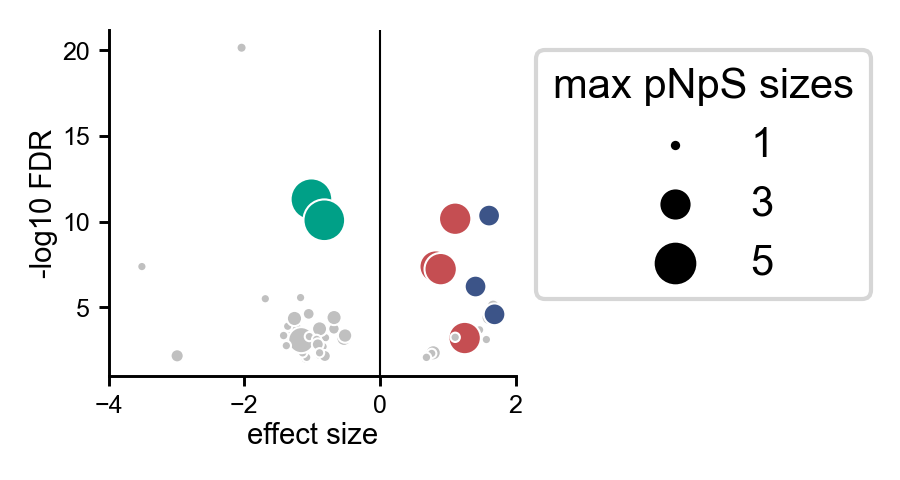

In [116]:
output_dir = 'outputs/figures'
output_name = '3B_association_hits.pdf'

# keep only those meeting 0.01 FDR
plot_df = aggregated_associations_df.copy()
plot_df.loc[:, '-log10 global-fdr'] = -np.log10(plot_df.loc[:, 'global-fdr'])
plot_df = plot_df.loc[plot_df.loc[:, 'global-fdr'] < 0.01]

# get max pNpS of genes
max_pnps = np.max(
    pnps_df.loc[:, pd.IndexSlice[:, 'pNpS']], axis=1)

# highlight WhiB6 and Rv0042c
plot_df.loc[:, 'highlight'] = 'None'
plot_df.loc[plot_df.variant == 'Rv3862c', 'highlight'] = 'whiB6'
plot_df.loc[plot_df.variant == 'Rv0042c', 'highlight'] = 'Rv0042c'
plot_df.loc[plot_df.variant == 'Rv2752c', 'highlight'] = 'rnj'

# get pNpS of variant genes
variant_pnps = max_pnps.loc[plot_df.variant.values].values
size_array = linearScaleArray(variant_pnps, 5, 100, floor=1)

fig, ax = plt.subplots(1, 1, figsize=(1.75, 1.5))

sns.scatterplot(
    data=plot_df,
    y='-log10 global-fdr',
    x='beta',
    s=size_array,
    hue='highlight',
    lw=0.5,
    palette={
        'None': colors['gray'],
        'rnj': colors['dred'],
        'whiB6': colors['dgreen'],
        'Rv0042c': colors['dblue']},
    legend=False)
ax.axvline(
    0, 0, 1, lw=0.5, color='k')


# Manually create the legend
handles, labels = ax.get_legend_handles_labels()
legend_array = linearScaleArray([1, 3, 5], 5, 100, floor=1)
size_legend = [plt.scatter(
    [0], [-1], marker='o', lw=0, color='k', s=v)
    for v in legend_array]
labels_size = ['1', '3', '5']
legend = ax.legend(
    size_legend, labels_size,
    title='max pNpS sizes', loc='upper left', bbox_to_anchor=(1, 1))

# set limits and labels
ax.set_ylim(1, ax.get_ylim()[1])
ax.set_yticks(
    [5, 10, 15, 20])
ax.set_xticks(
    [-4, -2, 0, 2])

ax.set_xlabel('effect size')
ax.set_ylabel('-log10 FDR')
sns.despine()

plt.savefig(f'{output_dir}/{output_name}', format='pdf', bbox_inches='tight', dpi=300)

# Run pyseer against esxB & esxA

In [5]:
##
variant_vcb = 'datasets/variants/rnaseq/241103_variant_calls.vcb'
event_vcb = 'datasets/variants/rnaseq/241103_event_calls.vcb'
input_vcf = 'datasets/variants/rnaseq/merged.filtered.vcf.gz'
genetable_path = 'datasets/gt_mtb_h37rv.csv'
output_vcf = 'tmp/pyseer_input.tmp.vcf'
output_regions = 'tmp/regions.tmp.tsv'
contig_name = 'NC_000962'

maximum_miss_fraction = 0.05
maximum_reversions = 0
maximum_frequency = 0.25
minimum_events_per_gene = 5
##

# load gene table
gene_table = pd.read_csv(
    'datasets/gt_mtb_h37rv.csv', index_col=0)

# load in event vcb
annotated_event_df = pd.read_csv(
    f'{event_vcb}/event_calls.annotated.csv',
    index_col=['pos', 'ref', 'alt'])
    
# filter to get likely deleterious variants
deleterious_settings = {
    'Annotation': lambda x: any([atype in str(x) for atype in [
        'frameshift_variant',
        'stop_gained',
        'start_lost']]),
    'SIFT_score': lambda x: float(x) < 0.05}
deleterious_event_df = filterDataFrame(
    annotated_event_df, function_dict=deleterious_settings)

# variant call metrics
variant_calls = vt.CallBytestream(
    variant_vcb, True, False)
# check fraction of variant calls missing from each
miss_fraction = np.asarray([
    np.sum(variant_calls.calls.loc[vidx] == 2) / len(variant_calls.calls.col)
    for vidx in deleterious_event_df.index])
# check fraction of variant calls == alt
alt_fraction = np.asarray([
    np.sum(variant_calls.calls.loc[vidx] == 1) / len(variant_calls.calls.col)
    for vidx in deleterious_event_df.index])

# check the number of reversions detected
reversion_count = deleterious_event_df.loc[
    :, ['reversions_to_ref', 'reversions_to_alt']].sum(1)

# apply variant filters
variant_mask = np.all([
    miss_fraction <= maximum_miss_fraction,
    reversion_count <= maximum_reversions,
    alt_fraction <= maximum_frequency,], axis=0)
vfiltered_df = deleterious_event_df.loc[variant_mask]
print(f'{variant_mask.sum()}/{len(variant_mask)} variants pass all variant filters')

# apply gene event filters
all_geneid = np.unique(vfiltered_df.Gene_ID)
allowed_geneid = []
for geneid in all_geneid:
    if np.sum(vfiltered_df.loc[vfiltered_df.Gene_ID == geneid, 'steps']) >= minimum_events_per_gene:
        allowed_geneid.append(geneid)
writeRegionTable(genetable_path, output_regions, allowed_geneid, contig_name=contig_name)
print(f'{len(allowed_geneid)}/{len(all_geneid)} genes with variants pass event per gene filter')


# get final variants
output_variants = vfiltered_df.loc[np.isin(vfiltered_df.Gene_ID, allowed_geneid)]
print(f'{len(output_variants)}/{len(deleterious_event_df)} variants written to output.')

# write variants
filterVCF(input_vcf, output_vcf, output_variants.sort_values('pos').index)

6472/7103 variants pass all variant filters
312/2654 genes with variants pass event per gene filter
2126/7103 variants written to output.
writing 2123 unique (pos, ref, alt) records / 2126 total annotated variants


In [6]:
tree_path = 'datasets/trees/cohort_trees/rnaseq_strains.iq_snp_gtr_cons.rooted.contree.nwk'
output_path = 'outputs/tables/TableS6_esxBA_gene_associations.csv'

# load in diversity dataframe
target_genes = ['Rv3874', 'Rv3875']

# load expression data
exp_data_path = 'rnaseq/normalized_isolate_expression.csv'
exp_df = pd.read_csv(
    exp_data_path,
    header=[0, 1, 2], index_col=0)
# get relative expression by strain
mean_exp = exp_df.T.groupby('strain').mean().mean()
rel_exp = exp_df - mean_exp.values.reshape(-1, 1)
rel_exp_by_strain = rel_exp.T.groupby('strain').mean()


aggregated_associations = []
for geneid in tqdm.tqdm(target_genes):
    try:
        pyseer_output = runPyseerBurdenLMM(
            rel_exp_by_strain.loc[:, geneid],
            tree_path,
            f'{output_vcf}.gz',
            output_regions)
        aggregated_associations.append(
            pyseer_output)
    except TimeoutError:
        print(geneid, 'timed out')
# concatenate associations for each gene together
aggregated_associations_df = pd.concat(
    aggregated_associations, axis=0)
# add a global FDR
aggregated_associations_df.insert(
    7, 'global-fdr',
    multipletests(
        aggregated_associations_df.loc[:, 'lrt-pvalue'],
        method='fdr_bh', alpha=0.01)[1])
# add names and output
aggregated_associations_df.insert(
    1, 'input_name', gene_table.loc[aggregated_associations_df.input_gene, 'gene'].values)
aggregated_associations_df.insert(
    3, 'variant_name', gene_table.loc[aggregated_associations_df.variant, 'gene'].values)
aggregated_associations_df.sort_values('global-fdr').to_csv(output_path)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.55s/it]
